In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vitaldb
import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv('clinical_data.csv')

In [3]:
# preprocess
caseids = vitaldb.find_cases(['SNUADC/ART', 'SNUADC/ECG_II', 'SNUADC/PLETH', 'Primus/CO2', 'Solar8000/BT'])

print(len(caseids))
print(caseids[:10])

3312
[1, 3, 4, 7, 10, 13, 14, 16, 17, 19]


In [4]:
#pre operative hypotention == 1
df_preop_htn = df[df['preop_htn']==1]

print(len(df_preop_htn))
print(df_preop_htn['caseid'].unique())

1965
[   1    4    5 ... 6380 6383 6385]


In [5]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        temp = a_set & b_set
        print(temp)
    else:
        print("No common elements") 
    return temp

In [6]:
caseids = common_member(caseids, df_preop_htn['caseid'].unique())
print(len(caseids))

{6144, 1, 2049, 2051, 4, 4098, 2055, 6152, 2057, 10, 4106, 2060, 2063, 16, 4115, 20, 4116, 6163, 6167, 4120, 6169, 28, 6173, 32, 34, 6180, 6184, 43, 6190, 6191, 4144, 2099, 52, 4149, 6199, 58, 2107, 60, 61, 4155, 6208, 66, 67, 2114, 69, 70, 2118, 4167, 4169, 74, 6217, 2124, 77, 6218, 2128, 83, 84, 2132, 4179, 87, 2136, 4186, 6235, 4191, 98, 2148, 104, 4201, 110, 4207, 2161, 2162, 4210, 4211, 4212, 118, 4213, 6258, 6264, 125, 2174, 4222, 128, 4223, 2178, 4225, 132, 2181, 6275, 135, 136, 137, 2183, 4233, 6277, 4237, 6279, 6281, 6283, 145, 2197, 4247, 6296, 2202, 2203, 6306, 2213, 168, 4265, 2218, 4266, 172, 2220, 4268, 4270, 6312, 177, 6314, 6316, 180, 6318, 6324, 4279, 4282, 6331, 190, 191, 4287, 6335, 4290, 195, 6339, 2246, 4294, 2248, 2249, 202, 4299, 6343, 6346, 206, 207, 208, 4305, 210, 6355, 4308, 2265, 6362, 4316, 4317, 222, 6368, 4322, 2276, 6373, 230, 6374, 232, 233, 2280, 6376, 236, 4333, 6378, 2287, 6383, 6385, 242, 243, 2291, 247, 2296, 258, 2306, 2307, 2309, 4354, 263, 266, 

In [7]:
data = []
for i in caseids:
    data.append(vitaldb.load_case(i, ['SNUADC/ART', 'SNUADC/ECG_II', 'SNUADC/PLETH', 'Primus/CO2', 'Solar8000/BT']))

In [8]:
print(data[0])

[[        nan         nan         nan  0.30000001         nan]
 [        nan         nan         nan  0.2                nan]
 [        nan         nan         nan  0.1                nan]
 ...
 [19.82659912 -0.285588    7.53564978         nan         nan]
 [25.75130081 -0.0485986  10.30049992         nan         nan]
 [        nan         nan         nan         nan         nan]]


In [9]:
# preprocess

# Initialize an empty list to collect dataframes
dfs = []

# Loop through each event's data
for event_id, event_data in enumerate(data):
    # Convert event data to dataframe
    df_event = pd.DataFrame(event_data, columns=['art', 'ecg_ii', 'pleth', 'co2', 'bt'])
    df_event = df_event.dropna()
    # Add event_id column
    df_event['event_id'] = event_id
    
    # Append to our list
    dfs.append(df_event)

# Concatenate all dataframes together
df = pd.concat(dfs, ignore_index=True)

print(df.shape)
print(df)

(6183777, 6)
                art    ecg_ii      pleth        co2         bt  event_id
0        111.660004 -0.433707  37.159401  45.400002  15.800000         0
1         84.998703 -0.285588  30.444599  31.200001  22.500000         0
2         75.124199 -0.413958  54.538601  30.700001  22.500000         0
3        133.384003 -0.433707  41.109200  48.700001  22.400000         0
4         95.860802 -0.413958  28.469700   5.000000  22.400000         0
...             ...       ...        ...        ...        ...       ...
6183772  130.421997  0.050147  39.529301   0.800000  35.000000      1111
6183773   80.061401  0.030398  39.924198  44.700001  35.000000      1111
6183774   63.274700 -0.009100  40.714199   1.100000  34.900002      1111
6183775  125.484001  0.030398  39.134300  43.700001  34.400002      1111
6183776   77.099098  0.069896  40.319199   5.000000  34.100002      1111

[6183777 rows x 6 columns]


In [10]:
sampling_rate = 30 # Resampling (Hz)
input_length = 60
# input_length = [30, 60] # Input data length (sec) 
pred_lag = 300
# pred_lag = [300, 600, 900] # Prediction lag for 300, 600, and 900 sec (5-, 10-, 15-min prediction) 
# pred_threshold = {'hypo': lambda x: x < 65, # Threshold for hypotension (mmHg)
#                    'normo': lambda x: x >= 65}
pred_min_length = {'hypo': 60, # Minimum duration (sec) for defining hypotensive event
                    'normo': 1200} # for non-hypotensive event (normal)
batch_size = 256

In [11]:
#train test split
num_train = int(0.6 * len(caseids))
num_val = int(0.2 * len(caseids))
num_test = len(caseids) - num_train - num_val

delay = sampling_rate * pred_lag

# Step 1: Split case IDs
unique_caseids = df['event_id'].unique()
np.random.shuffle(unique_caseids)  # Shuffle in place

train_caseids = unique_caseids[:num_train]
val_caseids = unique_caseids[num_train:num_train+num_val]
test_caseids = unique_caseids[num_train+num_val:]

# Step 2: Filter main dataframe
train_df = df[df['event_id'].isin(train_caseids)]
val_df = df[df['event_id'].isin(val_caseids)]
test_df = df[df['event_id'].isin(test_caseids)]

# Step 3: Create time series datasets
# Note: Since each event might have different lengths, you might need to handle each event separately or ensure they have the same length

train_dataset = keras.utils.timeseries_dataset_from_array(
    train_df.drop(columns=['event_id']).values[:-delay],
    train_df['art'].to_numpy()[delay:],
    sampling_rate=sampling_rate,
    sequence_length=pred_lag,
    shuffle=False,
    batch_size=batch_size
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    val_df.drop(columns=['event_id']).values[:-delay],
    val_df['art'].to_numpy()[delay:],
    sampling_rate=sampling_rate,
    sequence_length=pred_lag,
    shuffle=False,
    batch_size=batch_size
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    test_df.drop(columns=['event_id']).values[:-delay],
    test_df['art'].to_numpy()[delay:],
    sampling_rate=sampling_rate,
    sequence_length=pred_lag,
    shuffle=False,
    batch_size=batch_size
)

In [12]:
for samples, targets in train_dataset:
    print("Input shape:", samples.shape)
    print("Target shape:", targets.shape)
    
    break

print(len(train_dataset))

for samples, targets in val_dataset:
    print("Input shape:", samples.shape)
    print("Target shape:", targets.shape)
    break

Input shape: (256, 300, 5)
Target shape: (256,)
14511
Input shape: (256, 300, 5)
Target shape: (256,)


In [13]:
#Model part
# First dense NN model

# inputs = keras.Input(shape=(pred_lag, df.drop(columns=['event_id']).shape[1]))
# x = layers.Flatten()(inputs)
# x = layers.Dense(16, activation="relu")(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.h5", save_best_only=True, save_format='h5')]
# history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# model = keras.models.load_model("jena_dense.h5")

# print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

## Start from here

In [14]:
def create_sequences(input_data, target_data, look_back, forecast_horizon):
    X, y = [], []
    for i in range(len(input_data) - look_back - forecast_horizon + 1):
        X.append(input_data[i:(i + look_back)])
        y.append(target_data[(i + look_back):(i + look_back + forecast_horizon)])
    return np.array(X), np.array(y)

forecast_horizon = 5  # Predicting next 5 time steps

In [15]:
# Assuming you have already defined your train_df, val_df, and test_df as before
X_train, y_train = create_sequences(train_df.drop(columns=['event_id']).values, train_df['art'].values, input_length, forecast_horizon)
X_val, y_val = create_sequences(val_df.drop(columns=['event_id']).values, val_df['art'].values, input_length, forecast_horizon)
X_test, y_test = create_sequences(test_df.drop(columns=['event_id']).values, test_df['art'].values, input_length, forecast_horizon)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization

input_shape = (input_length, df.drop(columns=['event_id']).shape[1])

model = Sequential()
model.add(LSTM(720, activation="tanh", return_sequences=True, input_shape=input_shape))
model.add(BatchNormalization())
model.add(LSTM(480, activation="tanh"))
model.add(Dense(120, activation="tanh"))
model.add(Dense(forecast_horizon))  # Output layer with 'forecast_horizon' units

optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 720)           2090880   
                                                                 
 batch_normalization (Batch  (None, 60, 720)           2880      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 480)               2305920   
                                                                 
 dense (Dense)               (None, 120)               57720     
                                                                 
 dense_1 (Dense)             (None, 5)                 605       
                                                                 
Total params: 4458005 (17.01 MB)
Trainable params: 4456565 (17.00 MB)
Non-trainable params: 1440 (5.62 KB)
_______________

In [76]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])


Epoch 1/5
114497/114497 [==============================] - 45548s 398ms/step - loss: 415.0760 - mae: 13.1318 - val_loss: 358.0522 - val_mae: 11.7129
Epoch 2/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114497/114497 [==============================] - 46205s 404ms/step - loss: 366.4007 - mae: 12.0740 - val_loss: 356.7182 - val_mae: 11.5302
Epoch 3/5
114497/114497 [==============================] - 46795s 409ms/step - loss: 370.1382 - mae: 12.1904 - val_loss: 371.2664 - val_mae: 11.8205
Epoch 4/5
114497/114497 [==============================] - 46993s 410ms/step - loss: 437.0703 - mae: 14.0972 - val_loss: 509.1000 - val_mae: 16.5175
Epoch 5/5
114497/114497 [==============================] - 45961s 401ms/step - loss: 483.2746 - mae: 15.7490 - val_loss: 460.0024 - val_mae: 14.7188


In [19]:
model.load_weights('best_model.h5')
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

39931/39931 [==============================] - 4181s 105ms/step - loss: 350.3533 - mae: 11.3914
Test Loss: 350.3533020019531, Test MAE: 11.39143180847168


In [36]:
import matplotlib.pyplot as plt

# Assuming you have your actual and predicted values in multi-dimensional arrays
# Extracting only the 'art' column from both actual and predicted values
# Replace '0' with the correct index of the 'art' column
actual_values = y_test[:,0]  # Extracting the 'art' column from actual values
predicted_values = model.predict(X_test)  # Extracting the 'art' column from predicted values

39931/39931 [==============================] - 4602s 115ms/step


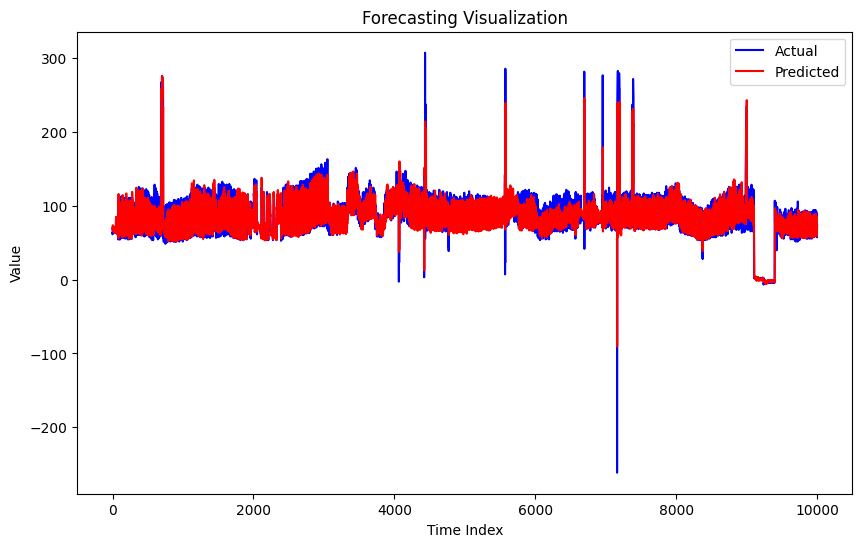

In [37]:
# Creating a time series index for the first 10,000 points
time_index = range(10000)

# Slicing the actual and predicted values to include only the first 10,000 points
actual_values_sliced = actual_values[:10000]
predicted_values_sliced = predicted_values[:,0][:10000]

# Plotting the actual values
plt.figure(figsize=(10, 6))
plt.plot(time_index, actual_values_sliced, label='Actual', color='blue')

# Plotting the predicted values
plt.plot(time_index, predicted_values_sliced, label='Predicted', color='red')

# Adding title and labels
plt.title('Forecasting Visualization')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [20]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from sklearn.preprocessing import MinMaxScaler
# from keras.preprocessing.sequence import TimeseriesGenerator

# # Assuming pred_lag and number of features are defined correctly
# input_shape = (pred_lag, df.drop(columns=['event_id']).shape[1])

# inputs = keras.Input(shape=input_shape)
# x = layers.LSTM(480, activation="tanh", return_sequences=True)(inputs)  # Default activation function is tanh
# x = layers.BatchNormalization()(x)
# x = layers.LSTM(240, activation="tanh")(x)
# x = layers.Dense(120, activation="tanh")(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# optimizer = keras.optimizers.Adam()

# model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
# model.summary()


In [21]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# history = model.fit(train_dataset, epochs=1, validation_data=val_dataset, callbacks=[early_stopping, model_checkpoint])

# model.load_weights('best_model.h5')

In [22]:
# loss, mae = model.evaluate(test_dataset)
# print(f"Test MAE: {mae}")